## Getting Started

This is a guide how to get started solving an example problem using *pymoo*. 

In this guide we are going to solve a bi-objective problem with the following definition:


$$
\begin{align*} 
\begin{split}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\max \;\; & f_2(x) = -(x_1-1)^2 - x_2^2 \\[2mm] 
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9) \leq 0\\ 
                       & g_2(x) = 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \geq 0\\ 
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2
\end{split}
\end{align*}
$$


 The contour plot looks as follows:

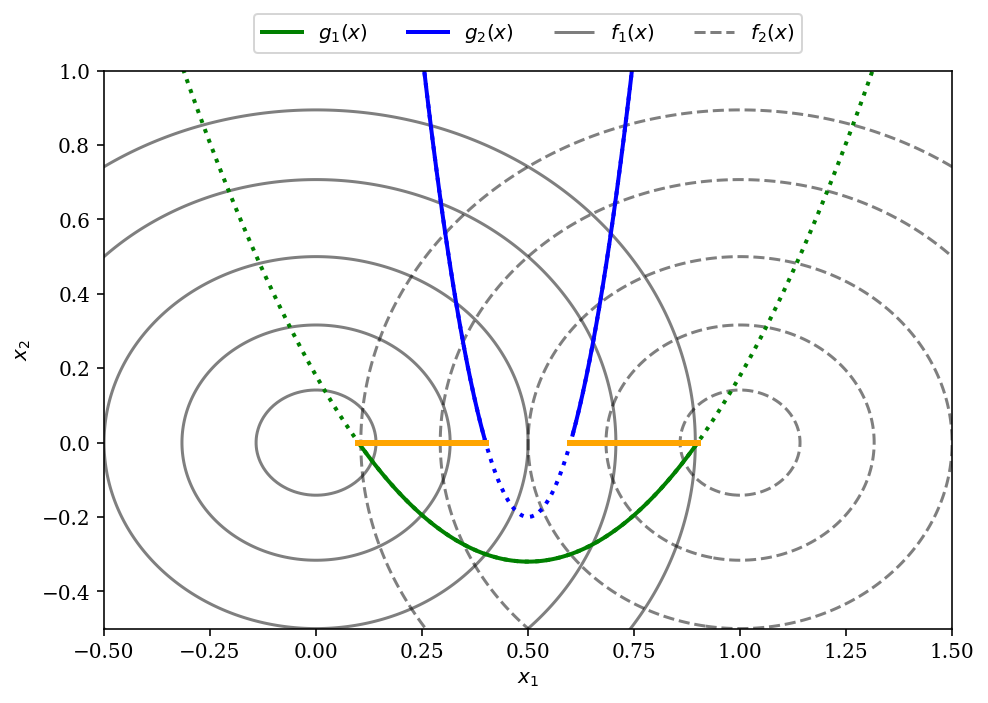

In [14]:
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))

F1 = X1**2 + X2**2
F2 = (X1-1)**2 + X2**2
G = X1**2 - X1 + 3/16

G1 = 2 * (X1[0] - 0.1) * (X1[0] - 0.9)
G2 = 20 * (X1[0] - 0.4) * (X1[0] - 0.6)


import matplotlib.pyplot as plt
plt.rc('font', family='serif')

levels = [0.02, 0.1, 0.25, 0.5, 0.8]
plt.figure(figsize=(7, 5))
CS = plt.contour(X1, X2, F1, levels, colors='black', alpha=0.5)
CS.collections[0].set_label("$f_1(x)$")

CS = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5)
CS.collections[0].set_label("$f_2(x)$")

plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

### Define a Problem

In *pymoo* all functions are supposed to be **minimized**. However, in case of maximization (as you might alread now), you can simply multiply the objective by -1 and then minimize it. In our case, the second objective $f_2(x) = -(x_1-1)^2 - x_2^2$ to be maximized will become $f_2(x) = (x_1-1)^2 + x_2^2$ to be minimized.

Most of the algorithms in *pymoo* are able to handle constraints. A solution is defined to be feasible or infeasible as follows:


$$ \begin{cases}
\text{feasible,} \quad \quad \sum_i^n \langle g_i(x)\rangle = 0\\
\text{infeasbile,} \quad \quad \quad \text{otherwise}\\
\end{cases}
$$

$$
\text{where} \quad \langle g_i(x)\rangle =
\begin{cases}
0, \quad \quad \; \text{if} \; g_i(x) \leq 0\\
g_i(x), \quad  \text{otherwise}\\
\end{cases}
$$



Therefore, a constraint counts as violated when $g_i(x)$ is *positive* for at least one constraint. For the purpose of convergence it is useful to make sure the positive value corresponds to the amount of infeasibility. If $g_i(x)$ returns a negative value no constraint violation does exist and the solution is considered as feasible. 
In *pymoo* 
Therefore, the constraint function $g_1(x)$ needs to be converted to a $\leq 0$ constraint: $g_1(x) = 10 \, x_1  (x_1 - 0.25) \leq 0$.

Finally, the problem to be defined is:

$$
\begin{align*} 
\begin{split}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\min \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\[2mm] 
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9) \leq 0\\ 
                       & g_2(x) = - 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \leq 0\\ 
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2
\end{split}
\end{align*}
$$


The implementation of this problem is the follows: First, the problem class needs to be defined. One way to do that is by defining an object which inherits from the Problem class. The instructor needs to set the number of variables *n_var*, the number of objectives *n_obj*, the number of constraints *n_constr* and the variable boundaries (if applicable to the variable type). Moverover, the *\_evaluate* function needs to be overwritten. The input *x* is a 2d-array, where each row represents an entry to be evaluated.

In [24]:
import autograd.numpy as anp
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, 
                         n_obj=2, 
                         n_constr=2, 
                         xl=anp.array([-2,-2]), 
                         xu=anp.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:,0]**2 + x[:,1]**2
        f2 = (x[:,0]-1)**2 + x[:,1]**2
        
        g1 = 10*(x[:, 0]-0.1) * (x[:, 0]-0.9)
        g2 = - 20*(x[:, 0]-0.4) * (x[:, 0]-0.6)
        
        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([g1, g2])
        
        
    # --------------------------------------------------
    # Pareto-front - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2
        
        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2
        
        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)
    
    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)
        
        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)
    
problem = MyProblem()


### Initialize an Algorithm




Second, an algorithm to solve the problem need to be defined. Depending on the optimization problem different algorithms can be used to optimize the problem. Choosing an apropriate algorithm with suitable hyperparameters is a challange itself.
In our example, a bi-objective problem with one constraint can solved by using the well-known [NSGA-II](/algorithms/nsga2.html).

In [35]:
from pymoo.algorithms.nsga2 import nsga2
from pymoo.factory import get_sampling, get_crossover, get_mutation

method = nsga2(pop_size=40,
               n_offsprings=20,
               sampling=get_sampling("real_random"),
               crossover=get_crossover("real_sbx", prob=0.9, eta=15),
               mutation=get_mutation("real_pm", eta=20),
               eliminate_duplicates=True,
               )

### Define a Termination Criterion

In [36]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 20)

### Optimize

Third, we are solving the problem with the method we have just defined. The [Result](/api/model.html#pymoo.model.result.Result) object provides the corresponding *X* and *F* values and much more information. For instance, because we have enabled the *save_history* flag, we can analyze the optimization run over time and track the performance.

In [37]:
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.util import plotting

res = minimize(problem,
               method,
               termination=termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)


n_gen | n_eval  | cv (min/avg)        | igd      | gd       | hv      
1     | 40      | 0.000000 / 2.13E+01 | 0.323662 | 1.114456 | 0.259340
2     | 60      | 0.000000 / 6.284760 | 0.296066 | 0.818567 | 0.270122
3     | 80      | 0.000000 / 1.841528 | 0.295227 | 0.873295 | 0.270122
4     | 100     | 0.000000 / 0.285565 | 0.278819 | 0.966263 | 0.286514
5     | 120     | 0.000000 / 0.000704 | 0.105674 | 0.871739 | 0.394301
6     | 140     | 0.000000 / 0.000000 | 0.062259 | 0.225310 | 0.420544
7     | 160     | 0.000000 / 0.000000 | 0.036746 | 0.082604 | 0.429691
8     | 180     | 0.000000 / 0.000000 | 0.024970 | 0.031416 | 0.438966
9     | 200     | 0.000000 / 0.000000 | 0.023174 | 0.014485 | 0.441919
10    | 220     | 0.000000 / 0.000000 | 0.020693 | 0.011697 | 0.442209
11    | 240     | 0.000000 / 0.000000 | 0.019779 | 0.011970 | 0.442353
12    | 260     | 0.000000 / 0.000000 | 0.017860 | 0.009644 | 0.444560
13    | 280     | 0.000000 / 0.000000 | 0.017246 | 0.008729 | 0.445729
14    

### Visualize

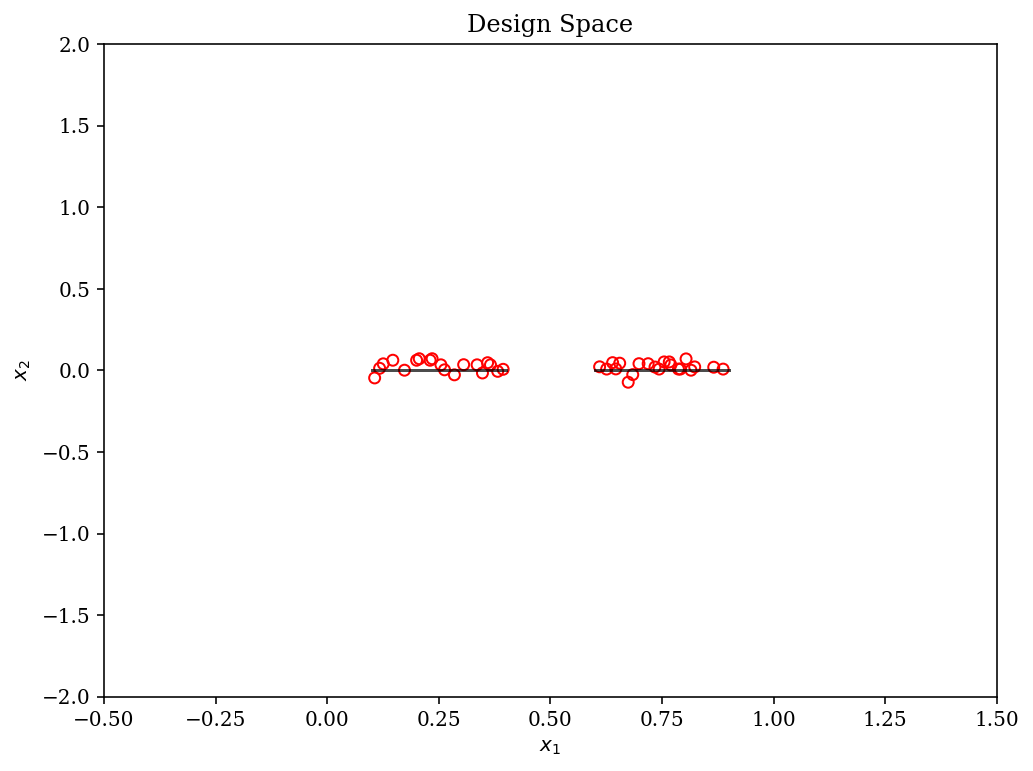

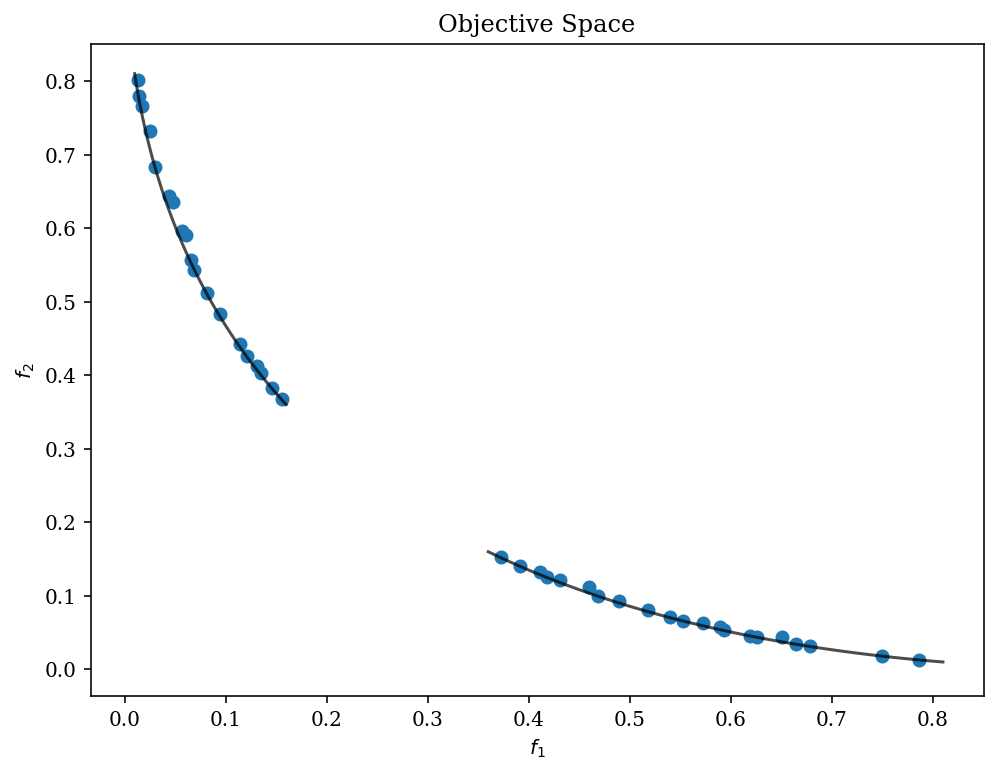

In [38]:
from pymoo.visualization.scatter import scatter

# get the pareto-set and pareto-front for plotting
ps = problem.pareto_set(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=False)


# Design Space
plot = scatter(title = "Design Space", axis_labels="x")
plot.add(res.X, s=30, facecolors='none', edgecolors='r')
plot.add(ps, plot_type="line", color="black", alpha=0.7)
plot.do()
plot.apply(lambda ax: ax.set_xlim(-0.5, 1.5))
plot.apply(lambda ax: ax.set_ylim(-2, 2))
plot.show()


# Objective Space
plot = scatter(title = "Objective Space")
plot.add(res.F)
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()

### Performance Tracking

Because we also saved the history, we can now analyze the convergence over time. To measure the performance we need to decide what metric to be used. Here, we have using Hypervolume.

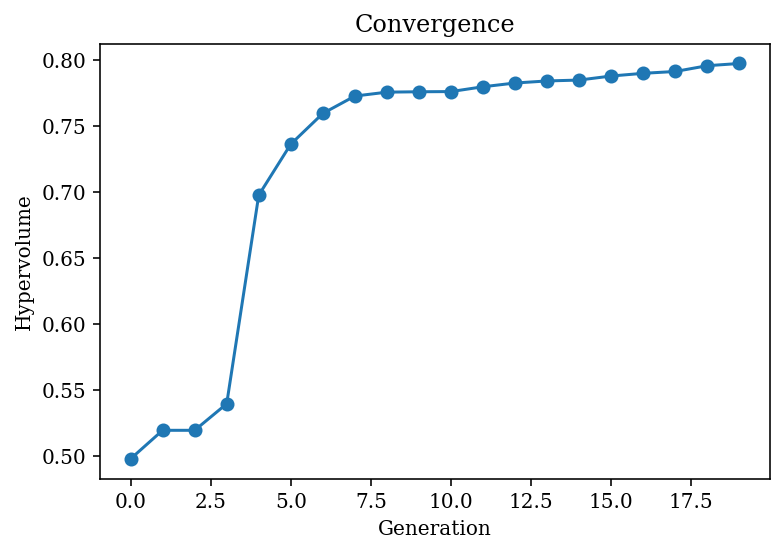

In [31]:
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([1.0, 1.0]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# visualze the convergence curve 
plt.plot(np.arange(len(hv)), hv, '-o')
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.show()


### Analysis of Gradients

In [ ]:
X = np.random.random((10,2))
F, dF, G, dG = problem.evaluate(X, return_values_of=["F", "dF", "G", "dG"])

print("df1/dx1", 2*X[0, 0], dF[0, 0, 0])
print("df1/dx2", 2*X[0, 1], dF[0, 0, 1])

print("df2/dx1", 2*(X[0, 0] - 1), dF[0, 1, 0])
print("df2/dx2", 2*X[0, 1], dF[0, 1, 1])

In [44]:
from pymoo.performance_indicator.kktpm import KKTPM

kktpm = KKTPM()
val = kktpm.calc(res.X, problem)

print(val)

X = np.random.random((10,2))
F, dF, G, dG = problem.evaluate(res.X, return_values_of=["F", "dF", "G", "dG"])

print("df1/dx1", 2*X[0, 0], dF[0, 0, 0])
print("df1/dx2", 2*X[0, 1], dF[0, 0, 1])

print("df2/dx1", 2*(X[0, 0] - 1), dF[0, 1, 0])
print("df2/dx2", 2*X[0, 1], dF[0, 1, 1])


ValueError: operands could not be broadcast together with shapes (2,2) (100,2) 